In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.1.0
TFP version: 0.9.0


***
<a id="coding_tutorial_2"></a>
## Probabilistic layers

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

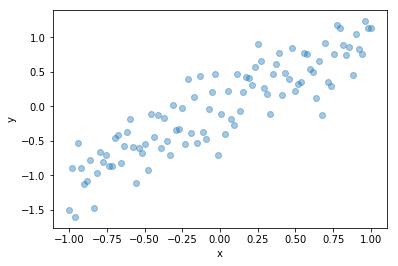

In [ ]:
# Create and plot 100 points of training data

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Deterministic linear regression with MSE loss

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


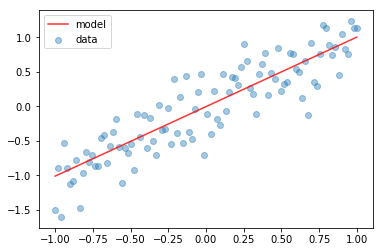

In [ ]:
# Create and train deterministic linear model using mean squared error loss

# Create linear regression via Sequential model
model = Sequential([
    Dense(units=1, input_shape=(1,))
])
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)

# Plot the data and model
plt.scatter(x_train, y_train, alpha=0.4, label='data')
plt.plot(x_train, model.predict(x_train), color='red', alpha=0.8, label='model')
plt.legend()
plt.show()

In [ ]:
# Examine the model predictions
x_sam=np.array([[0]])
y_sam=model(x)
print(y_sam)

tf.Tensor([[-0.00468677]], shape=(1, 1), dtype=float32)


In [ ]:
# Create probabilistic regression with normal distribution as final layer

event_shape=1
model = Sequential([
    Dense(units=tfpl.IndependentNormal.params_size(event_shape), input_shape=(1,)),
         tfpl.IndependentNormal(event_shape)
])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 2)                 4         
_________________________________________________________________
independent_normal_4 (Indepe ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train model using the negative loglikelihood
def nll(y_true,y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train,y_train,epochs=100,verbose=False)

In [ ]:
# Examine the distribution created as a feedforward value
y_model=model(x_sam)
print(y_model)


tfp.distributions.Independent("sequential_13_independent_normal_4_IndependentNormal_Independentsequential_13_independent_normal_4_IndependentNormal_Normal", batch_shape=[1], event_shape=[1], dtype=float32)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



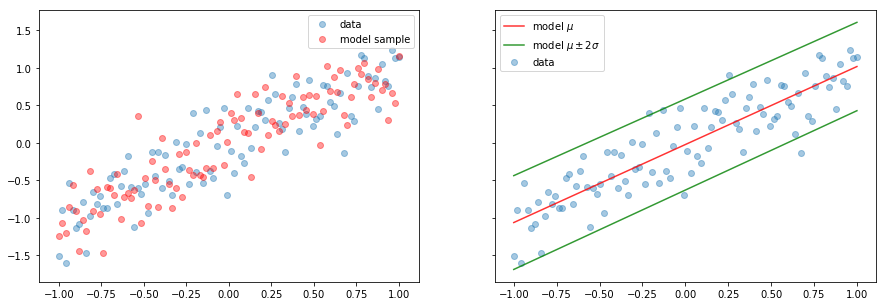

In [ ]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

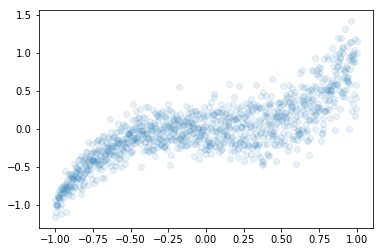

In [ ]:
# Create and plot 10000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [ ]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 18        
_________________________________________________________________
independent_normal_5 (Indepe ((None, 1), (None, 1))    0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train model

model.fit(x_train, y_train, epochs=200, verbose=False)
model.evaluate(x_train, y_train)

1000/1000 [==============================] - 0s 269us/sample - loss: -0.1704


-0.1704305353164673


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



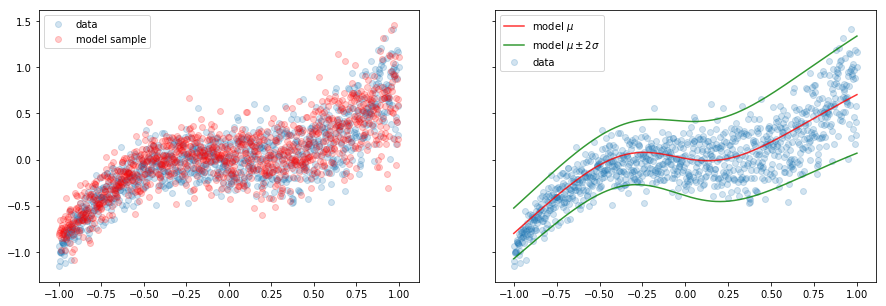

In [ ]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='data')
ax1.scatter(x_train, y_sample, alpha=0.2, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()